# Visualising the results of extracting the internal models

In [1]:
import os
import json
import textwrap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from llm_elicited_priors.plotting import graph_theme
from llm_elicited_priors.utils import cut_end_points

import matplotlib_inline
import matplotlib.ticker as mpl_ticker
import matplotlib.transforms as mpl_transforms
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

from llm_elicited_priors.metrics import e_coefficient

In [2]:
width = 7.1413/0.75
colwidth = 3.433071
linewidth = 7.12598

In [3]:
RESULTS_PATH = "./priors/internal_model/prior_with_multiple_messages/"
DATASETS = [
    d 
    for d in os.listdir(RESULTS_PATH) 
    if os.path.isdir(os.path.join(RESULTS_PATH, d))
]

In [4]:
results_dict = {dataset: {} for dataset in DATASETS}

for dataset in DATASETS:
    with open(
        os.path.join(RESULTS_PATH, dataset, "mle_loss.json"), "r"
    ) as f:
        results_dict[dataset]["mle_loss"] =  json.load(f)

    with open(
        os.path.join(RESULTS_PATH, dataset, "prior_parameter_samples.json"), "r"
    ) as f:
        results_dict[dataset]["prior_parameter_samples"] =  json.load(f)

    if dataset == "fake_data":
        with open(
            os.path.join(RESULTS_PATH, dataset, "samples.json"), "r"
        ) as f:
            results_dict[dataset]["samples"] =  json.load(f)

In [5]:
y_true_fake_data = (
    np.array(results_dict["fake_data"]["samples"][0])
    @ np.array([2, -1, 1])
)
n_samples = y_true_fake_data.shape[-1]
y_true_fake_data = y_true_fake_data.reshape(-1, n_samples)


y_pred_icl_fake_data = [
    y 
    for yl in results_dict["fake_data"]["samples"][1]
    for y in yl
]

len_of_y_pred_icl_fake_data = [len(y) for y in y_pred_icl_fake_data]

y_true_fake_data = np.array([
    y_true 
    for y_true, y_pred in zip(y_true_fake_data, y_pred_icl_fake_data) 
    if len(y_pred) == n_samples
])

y_pred_icl_fake_data = np.array([
    y_pred 
    for y_pred in y_pred_icl_fake_data
    if len(y_pred) == n_samples
])

In [6]:
rmse = np.sqrt(
    np.mean(
        (y_pred_icl_fake_data.ravel() - y_true_fake_data.ravel()) ** 2
    )
)
rmse

9.19571951395166

In [7]:
# binned rmse
n_bins = 20
bins = np.linspace(y_true_fake_data.min(), y_true_fake_data.max(), n_bins)

binned_rmse = np.array([
    np.sqrt(
        np.mean(
            (
                (
                    y_pred_icl_fake_data[
                        (y_true_fake_data >= bins[i]) 
                        & (y_true_fake_data < bins[i+1])
                    ].ravel()
                ) 
                - 
                (
                    y_true_fake_data[
                        (y_true_fake_data >= bins[i]) 
                        & (y_true_fake_data < bins[i+1])
                    ].ravel()
                )
            ) ** 2
        )
    )
    for i in range(len(bins) - 1)
])

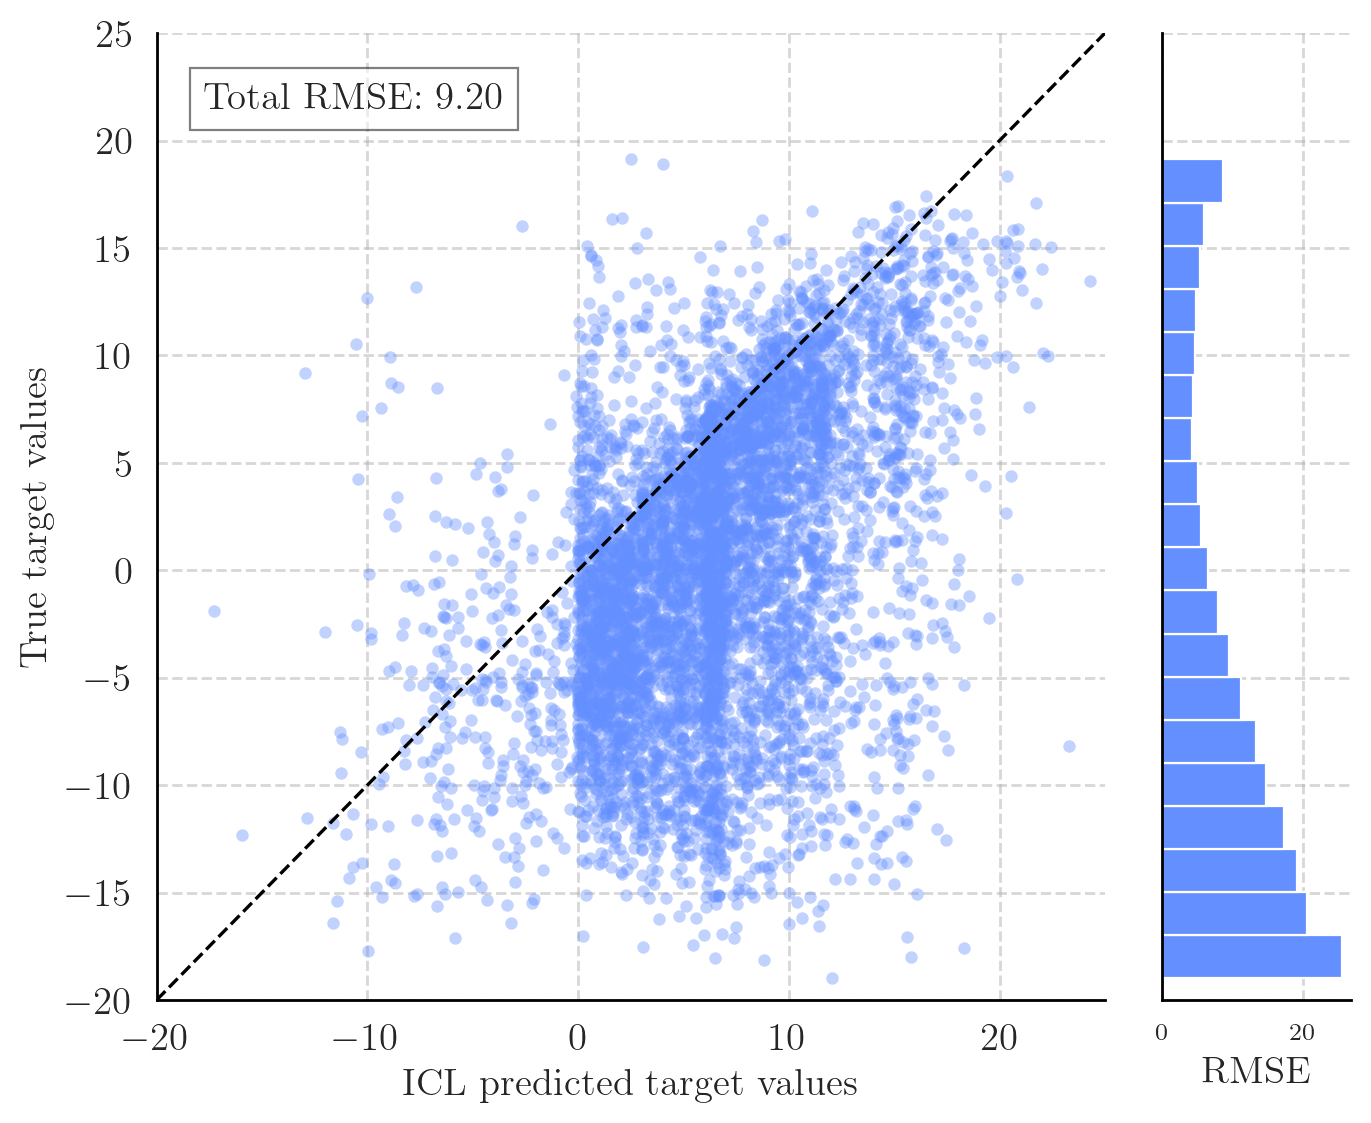

In [8]:
fontsize = 14

with graph_theme():
    plt.close()

    fig, axes = plt.subplots(
        1, 2,
        figsize=(2*colwidth, 2*0.8*colwidth), 
        width_ratios=[1, 0.2],
        sharey=True,
    )

    ax1 = axes[0]

    ax1.scatter(
        y_pred_icl_fake_data.ravel(),
        y_true_fake_data.ravel(),
        alpha=0.4,
        s=20,
        linewidths=0,
    )

    ax1.axline([0, 0], [1, 1], color="black", linestyle="--")
    ax1.set_ylabel("True target values", fontsize=fontsize)
    ax1.set_xlabel("ICL predicted target values", fontsize=fontsize)

    ax1.tick_params(axis='both', which='major', labelsize=fontsize)

    ax1.text(
        0.05, 0.95, 
        f"Total RMSE: {rmse:.2f}", 
        transform=ax1.transAxes,
        fontsize=fontsize,
        verticalalignment='top',
        bbox=dict(
            facecolor='white',
            edgecolor='black',
            pad=5,
            alpha=0.5
        )
    )

    ax1.set_xlim(-20, 25)
    ax1.set_ylim(-20, 25)

    ax2 = axes[1]
    ax2.barh(
        (bins[1:] + bins[:-1])/2,
        width=binned_rmse,
        height=np.diff(bins),
    )
    ax2.set_xlabel("RMSE", fontsize=fontsize)

    fig.subplots_adjust(
        wspace=0.1,
        top=0.98,
        bottom=0.1,
        left=0.11,
        right=0.98,
    )

    fig.savefig("results/ICL_vs_true_target_values_fake_data.pdf")

    plt.show()

## Prior distribution:

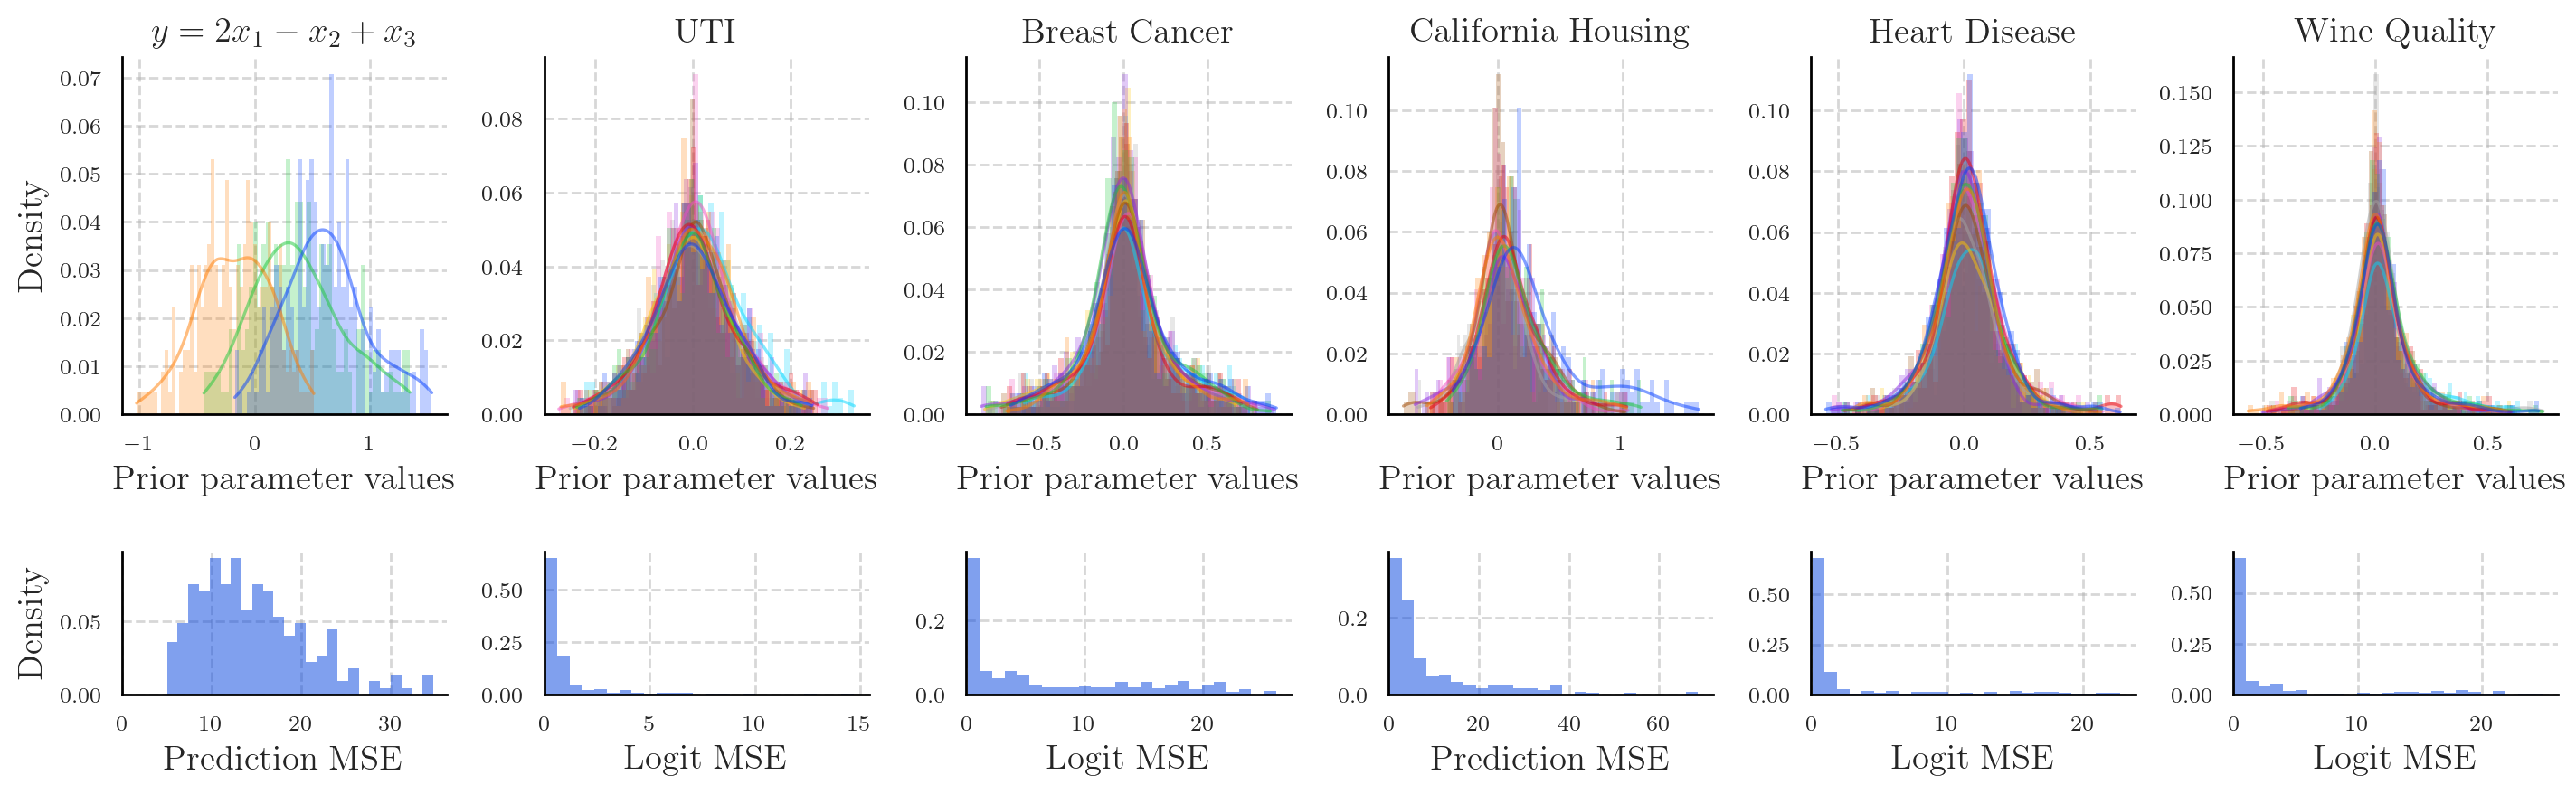

In [9]:
plt.close()

fontsize = 14

dataset_order = [
    "fake_data",
    "uti",
    "breast_cancer",
    "california_housing",
    "heart_disease",
    "wine_quality",
]

dataset_nice_names = {
    "fake_data": r"$y = 2 x_1 - x_2 + x_3$",
    "uti": "UTI",
    "breast_cancer": "Breast Cancer",
    "california_housing": "California Housing",
    "heart_disease": "Heart Disease",
    "wine_quality": "Wine Quality",
}

mle_hist_config = dict(
    alpha=0.5,
    edgecolor="black",
    linewidth=0.0,
    bins=25,
    kde=False,
    common_norm=False, 
    common_bins=False,
    stat="probability",
)

priors_hist_config = dict(
    alpha=0.25,
    palette="bright",
    linewidth=0.0,
    bins=50,
    kde=True,
    common_norm=False, 
    common_bins=False,
    stat="probability",
    line_kws=dict(
        alpha=.5,

    ),
)

n_rows = 2
n_cols = len(dataset_order)


with graph_theme():
    fig, axes = plt.subplots(
        n_rows, 
        n_cols, 
        figsize=(2*linewidth, 0.5*2*linewidth/1.618),
        height_ratios=[1, 0.4]
    )

    col = 0
    for dataset in dataset_order:
        
        # skipping if no result for this dataset
        if dataset not in DATASETS:
            print(f"No results for {dataset}")
            continue

        # loading the data
        mle_loss = np.array([
            a 
            for al in results_dict[dataset]["mle_loss"]
            for a in al
            if a is not None
        ])

        # getting parameters of weights - not intercept
        prior_parameter_samples = np.array([
            a 
            for al in results_dict[dataset]["prior_parameter_samples"] 
            for a in al
            if a is not None
        ])[:, 1:]

        # plotting the prior parameters
        ax = axes[0, col]
        sns.histplot(
            [cut_end_points(f, 2.5, 97.5) for f in prior_parameter_samples.T],
            ax=ax,
            legend=False,
            **priors_hist_config
        )

        ax.set_title(dataset_nice_names[dataset], fontsize=fontsize)
        ax.set_xlabel("Prior parameter values", fontsize=fontsize)

        if col > 0:
            ax.set_ylabel("")
        else:
            ax.set_ylabel("Density", fontsize=fontsize)


        # plotting the mle loss
        ax = axes[1, col]
        sns.histplot(
            cut_end_points((mle_loss), 2.5, 97.5),
            ax=ax,
            color="xkcd:blue",
            **mle_hist_config
        )
        
        ax.set_xlim(0)
        
        if dataset not in ["california_housing", "fake_data"]:
            ax.set_xlabel("Logit MSE", fontsize=fontsize)
        else:
            ax.set_xlabel("Prediction MSE", fontsize=fontsize)

        if col > 0:
            ax.set_ylabel("")
        else:
            ax.set_ylabel("Density", fontsize=fontsize)


        col += 1

    fig.subplots_adjust(
        hspace=0.55, wspace=0.3,
        left=0.045, right=0.99,
        top=0.925, bottom=0.125
    )

    fig.savefig(
        "results/prior_extraction_grid.pdf", 
    )
    fig.savefig(
        "results/prior_extraction_grid.svg", 
    )

    plt.show()

## Comparison with prior elicitation

In [10]:
import pymc as pm
import pytensor.tensor as pt
import scipy.stats as stats

from llm_elicited_priors.utils import cut_end_points

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling: [theta, w]
Sampling: [theta, w]
Sampling: [theta, w]
Sampling: [theta, w]
Sampling: [theta, w]
Sampling: [theta, w]


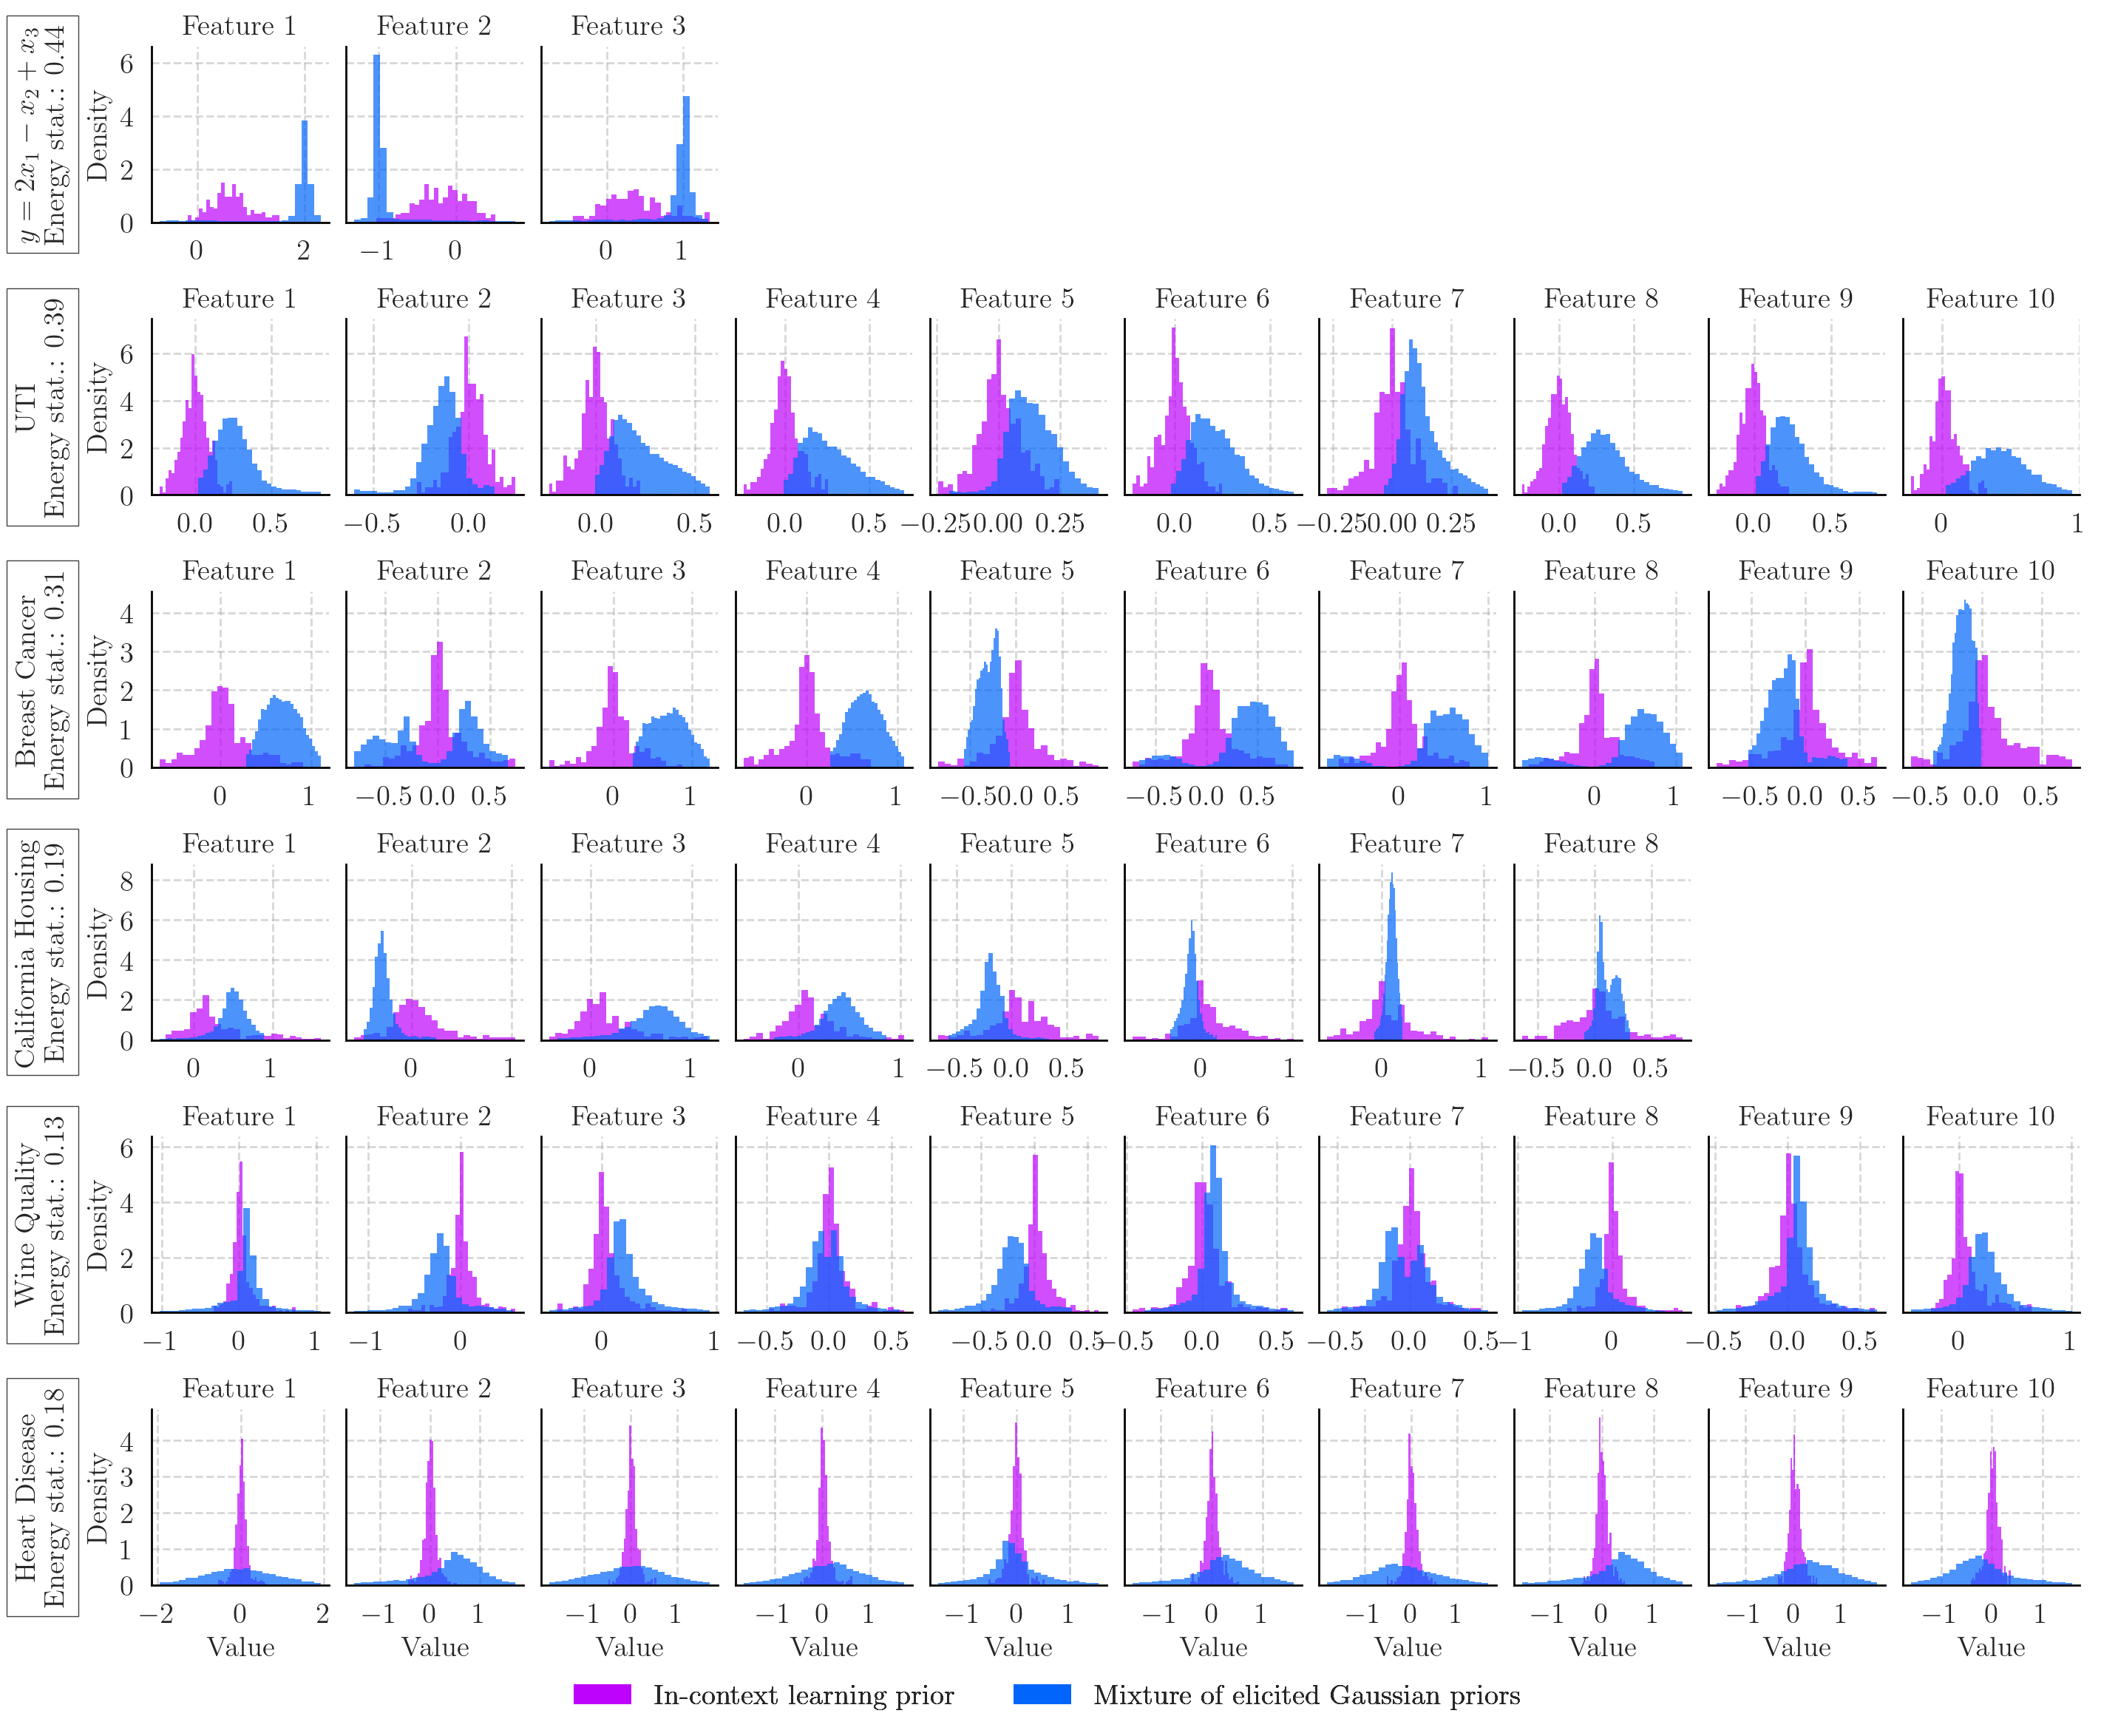

In [11]:
# number of rows so that the last row is not empty
fontsize = 14

plt.close()

dataset_order = [
    "fake_data",
    "uti",
    "breast_cancer",
    "california_housing",
    "wine_quality",
    "heart_disease",
]

dataset_nice_names = {
    "fake_data": r"$y = 2 x_1 - x_2 + x_3$",
    "uti": "UTI",
    "breast_cancer": "Breast Cancer",
    "california_housing": "California Housing",
    "wine_quality": "Wine Quality",
    "heart_disease": "Heart Disease",
}

palette = {
    "icl":"xkcd:bright purple",
    "pe":  "xkcd:bright blue",
}

alpha = 0.7

hist_config = dict(
    alpha = alpha,
    bins=25,
    edgecolor = "black",
    linewidth = 0.0,
    stat = "density",
)

ks_test_results = {}
e_coefficient_results = {}

with graph_theme():

    ncols = 10
    nrows = len(dataset_order)
    fig_width = 2*linewidth
    fig_height = 2*1.1*1.2*linewidth/1.618

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(fig_width, fig_height),
        sharey="row",
    )

    for d_i, dataset in enumerate(dataset_order):

        # getting parameters of weights - not intercept
        prior_samples_icl = np.array([
            a 
            for al in results_dict[dataset]["prior_parameter_samples"] 
            for a in al
            if a is not None
        ])[:, 1:]
        N_FEATURES = prior_samples_icl.shape[1]
        PRIORS_DIR = "./priors/elicitation/gpt-3-5-turbo-0125"
        
        # load priors
        priors = []

        prior_files = [f for f in os.listdir(PRIORS_DIR) if f.startswith(dataset)]

        for prior_file in prior_files:
            prior = np.load(os.path.join(PRIORS_DIR, prior_file))
            priors.append(prior)

        priors = np.stack(priors)

        priors = priors[:, 1:(N_FEATURES + 1), :]
        n_priors = priors.shape[0]
        with pm.Model() as model:

            w = pm.Dirichlet('w', a=np.ones(n_priors), shape=(N_FEATURES, n_priors))

            components = pm.Normal.dist(
                mu=priors[:, :, 0].T,
                sigma=priors[:, :, 1].T,
                shape=(N_FEATURES, n_priors)
            )

            theta = pm.Mixture(
                "theta",
                w=w,
                comp_dists=components,
            )

            prior_samples_pe = pm.sample_prior_predictive(samples=10000)

        prior_samples_pe = prior_samples_pe['prior']['theta'].to_numpy().squeeze()

        ks_test_values = [
            stats.ks_2samp(
                prior_samples_icl[:, feature], 
                prior_samples_pe[:, feature],
            ).pvalue
            for feature in range(N_FEATURES)
        ]

        ks_test_results[dataset] = ks_test_values

        e_coefficient_results[dataset] = e_coefficient(
            prior_samples_icl,
            prior_samples_pe,
            chunk_size=1000
        )

        for feature in range(N_FEATURES):

            ax = axes[d_i, feature]

            ax = sns.histplot(
                cut_end_points(prior_samples_icl[:, feature], 2.5, 97.5), 
                color=palette["icl"],
                ax=ax,
                **hist_config
            )
            ax = sns.histplot(
                cut_end_points(prior_samples_pe[:, feature], 2.5, 97.5), 
                color=palette["pe"],
                ax=ax,
                **hist_config
            )

            locator = mpl_ticker.MaxNLocator(
                nbins=4, steps=[1, 2, 4, 5], min_n_ticks=4
            )
            ax.yaxis.set_major_locator(locator)

            ax.set_title(f"Feature {feature + 1}", fontsize=fontsize)
            
            ax.tick_params(axis='both', which='major', labelsize=fontsize)
            
            if feature == 0:
                ax.set_ylabel("Density", fontsize=fontsize)
            else:
                plt.setp(ax.get_yticklabels(), visible=False)
            
            if d_i == nrows - 1:
                ax.set_xlabel("Value", fontsize=fontsize)
            else:
                ax.set_xlabel("") 
            
            if feature == 0:
                trans = mpl_transforms.blended_transform_factory(
                    fig.transFigure, ax.transAxes
                )
                fig.text(
                    0.01, 0.5,
                    f"{dataset_nice_names[dataset]}"
                    + f"\nEnergy stat.: {e_coefficient_results[dataset]:.2g}",
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform=trans,
                    fontsize=fontsize,
                    rotation=90,
                    multialignment="center",
                    bbox=dict(
                        facecolor='white', 
                        alpha=0.75, 
                        edgecolor='black',
                        linewidth=0.5
                    ),
                )

            if N_FEATURES < ncols:
                if feature == N_FEATURES - 1:
                    for unused_ax in axes[d_i, (feature+1):]:
                        unused_ax.remove()

        fig.subplots_adjust(
            hspace=0.55, wspace=0.1,
            left=0.075, right=0.99,
            top=0.975, bottom=0.08
        )

        fig.legend(
            handles=[
                mpatches.Patch(
                    facecolor=palette["icl"], alpha=alpha, 
                    linewidth=0.0, edgecolor="black",
                    label="In-context learning prior"
                ),
                mpatches.Patch(
                    facecolor=palette["pe"], alpha=alpha, 
                    linewidth=0.0, edgecolor="black",
                    label=r"Mixture of elicited Gaussian priors"
                ),
            ],
            loc="center",
            ncol=2,
            fontsize=fontsize,
            bbox_to_anchor=(0.5, 0.015),
            frameon=False,
        )

    fig.savefig(
        f"results/prior_extraction_icl_pe_grid.pdf", 
    )
    fig.savefig(
        f"results/prior_extraction_icl_pe_grid.svg", 
    )
    plt.show()

energy distance as a table

In [30]:
(
    pd.DataFrame.from_dict(
        ks_test_results, orient="index"
    )
    .transpose()
    .assign(
        feature=lambda x: x.index + 1
    )
)

,fake_data,uti,breast_cancer,california_housing,wine_quality,heart_disease,feature
0,5.020438e-181,1.352632e-273,1.013815e-305,1.478661e-64,2.016790e-57,3.157730e-48,1
1,1.168540e-168,2.735946e-164,1.584843e-37,3.164524e-140,1.417117e-183,2.682941e-175,2
2,1.316151e-111,2.174725e-202,2.826675e-314,3.681042e-103,1.509038e-114,9.797877e-49,3
3,NaN,2.334123e-225,2.499972e-321,1.683563e-77,1.321639e-23,1.038456e-57,4
4,NaN,2.546845e-119,1.199193e-222,8.635708e-105,2.104993e-189,1.189548e-45,5
5,NaN,2.654146e-214,2.215613e-161,1.605271e-77,3.869411e-58,9.009703e-88,6
6,NaN,6.395377e-140,1.733010e-176,2.345944e-42,5.950712e-27,7.132362e-79,7
7,NaN,5.351865e-311,1.181479e-213,2.016429e-34,1.374255e-160,3.061305e-146,8
8,NaN,5.602492e-279,2.749354e-123,NaN,1.727500e-48,7.318921e-93,9
9,NaN,2.905106e-321,9.563454e-156,NaN,3.112086e-122,1.334491e-97,10


In [ ]:
dataset_order = [
    #r"$y = 2 x_1 - x_2 + x_3$",
    "UTI",
    "Breast Cancer",
    "California Housing",
    "Wine Quality",
    "Heart Disease",
]

energy_statistic_df = (
    pd.DataFrame(
        e_coefficient_results,
        index=[0]
    )
    .rename(
        columns = {
            "breast_cancer": "Breast Cancer",
            "uti": "UTI",
            "california_housing": "California Housing",
            "heart_disease": "Heart Disease",
            "wine_quality": "Wine Quality",
        }
    )
    .map(lambda x: f"{x:.2f}")
    [dataset_order]
)
energy_statistic_df

,UTI,Breast Cancer,California Housing,Wine Quality,Heart Disease
0,0.39,0.31,0.19,0.13,0.18


In [32]:
print(
    energy_statistic_df.to_latex(index=False, escape=False,)
)

\begin{tabular}{lllll}
\toprule
UTI & Breast Cancer & California Housing & Wine Quality & Heart Disease \\
\midrule
0.39 & 0.31 & 0.19 & 0.13 & 0.18 \\
\bottomrule
\end{tabular}

